# Convolutional Neural Network (CNN)

### Imports

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

### Load the dataset

In [6]:
dataset = pd.read_csv("../dataset/FERPlus-master/fer2013.csv")
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### Data Preprocessing

In [7]:
def parse_pixels(pixel_str):
    pixels = np.array(pixel_str.split(), dtype=np.float32)
    return pixels.reshape(48, 48)

dataset['pixels'] = dataset['pixels'].apply(parse_pixels)

In [8]:
# stratify ensures that the distribution of emotions in the train and test sets are similar
train_data, test_data = train_test_split(dataset, test_size=0.2, stratify=dataset['emotion'], random_state=42)

In [9]:
class EmotionDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx]['pixels']
        label = self.data.iloc[idx]['emotion']

        if self.transform:
            image = self.transform(image)

        return image, label

### Data Augmentation

In [10]:
# First define the augmentation transforms we'll use to create new data
augmentation_transforms = [
    transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=1.0),  # Always flip
        transforms.RandomRotation(15),          # Rotate 15 degrees
        transforms.RandomResizedCrop((48, 48), scale=(0.8, 1.0)),  # Random crop
        transforms.ColorJitter(brightness=0.2, contrast=0.2),      # Brightness & contrast
        transforms.GaussianBlur(kernel_size=3),  # Gaussian blur
        transforms.ToTensor(),
    ]),
]

def create_augmented_dataset(original_data, augmentation_times=2):
    augmented_data = []

    for idx in range(len(original_data)):
        original_row = original_data.iloc[idx]
        pixels = original_row['pixels']
        emotion = original_row['emotion']
        usage = original_row['Usage']

        for _ in range(augmentation_times):  # Repeat augmentations on the original data
            for transform in augmentation_transforms:
                # Apply transformation
                augmented_pixels = transform(pixels)  # This gives us a tensor
                # Convert tensor to numpy and reshape correctly
                augmented_pixels = augmented_pixels.squeeze().numpy()  # Remove channel dimension

                # Create new row with augmented data
                augmented_row = {
                    'emotion': emotion,
                    'pixels': augmented_pixels,
                    'Usage': usage
                }
                augmented_data.append(augmented_row)

    # Convert augmented data to DataFrame
    augmented_df = pd.DataFrame(augmented_data)
    return augmented_df

# Create augmented versions of training data only
augmented_train_data = create_augmented_dataset(train_data, augmentation_times=10)

# Combine original and augmented training data
combined_train_data = pd.concat([train_data, augmented_train_data], ignore_index=True)
print(f"Original training data size: {len(train_data)}")
print(f"Augmented training data size: {len(augmented_train_data)}")
print(f"Combined training data size: {len(combined_train_data)}")

# Final transform for both original and augmented data
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),  # Keep original size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create new datasets with the expanded training data
train_dataset = EmotionDataset(combined_train_data, transform=train_transform)
test_dataset = EmotionDataset(test_data, transform=train_transform)

# Update data loaders with new datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Original training data size: 28709
Augmented training data size: 287090
Combined training data size: 315799


### Defining the CNN model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        # Placeholder for dynamically calculated size
        self.flatten_size = None

        # Fully connected layers will be initialized later
        self.fc1 = None
        self.fc2 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 7)

    def forward_conv(self, x):
        # Pass through convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        return x

    def forward(self, x):
        x = self.forward_conv(x)

        # Dynamically calculate flatten size if not set
        if self.flatten_size is None:
            self.flatten_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flatten_size, 512).to(x.device)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

### Training Loop

In [19]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, confusion_matrix
import os
import seaborn as sns

# Setup TensorBoard
log_dir = './logs'
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# Update training loop to include TensorBoard logging and checkpoint saving
best_val_loss = float('inf')
checkpoint_path = './model_checkpoint.pth'

In [ ]:
# Model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 15
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    accuracy = 100 * correct / total
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', accuracy, epoch)

    # Save the model checkpoint if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_path)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print(f'Validation Accuracy: {accuracy:.2f}%\n')

# Load the best model for final evaluation
model.load_state_dict(torch.load(checkpoint_path))

# Final evaluation with metrics and visualizations
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(7)]))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(7)], yticklabels=[str(i) for i in range(7)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Close TensorBoard writer
writer.close()

# # Training loop
# for epoch in range(num_epochs):
#     # Training phase
#     model.train()
#     running_loss = 0.0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
# 
#     avg_train_loss = running_loss / len(train_loader)
#     train_losses.append(avg_train_loss)
# 
#     # Validation phase
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
# 
#     avg_val_loss = val_loss / len(test_loader)
#     val_losses.append(avg_val_loss)
#     accuracy = 100 * correct / total
# 
#     print(f'Epoch {epoch + 1}/{num_epochs}')
#     print(f'Training Loss: {avg_train_loss:.4f}')
#     print(f'Validation Loss: {avg_val_loss:.4f}')
#     print(f'Validation Accuracy: {accuracy:.2f}%\n')
# 
# # Add visualization of training progress
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
# plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

### Model Evaluation

In [15]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')

Accuracy: 59.87740317637225%


### Visualizing Predictions

Displaying test images:


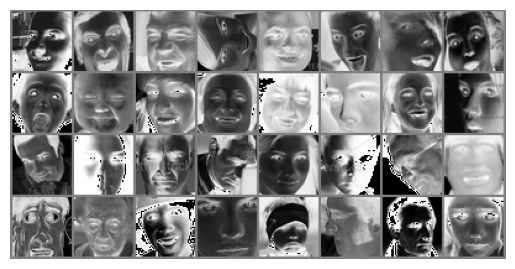

Predicted labels:  [3, 0, 3, 3, 3, 3, 3, 6, 6, 3, 3, 3, 3, 1, 3, 6, 3, 1, 0, 1, 3, 5, 1, 3, 4, 0, 3, 1, 5, 1, 5, 4]
True labels:       [3, 4, 3, 3, 3, 4, 6, 6, 6, 3, 3, 3, 3, 1, 3, 6, 3, 1, 2, 4, 5, 1, 0, 6, 4, 5, 3, 1, 1, 0, 5, 4]


In [16]:
import torch

# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

# Define a function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize (assuming mean=0.5, std=0.5 used during normalization)
    npimg = img.cpu().numpy()  # Ensure the image is moved to the CPU for display
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axes for cleaner visualization
    plt.show()

# Visualize predictions for a batch of test images
def visualize_predictions(model, test_loader, class_labels):
    # Determine device (use GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to the appropriate device
    model.to(device)
    model.eval()  # Ensure the model is in evaluation mode

    # Fetch a batch of test data
    try:
        dataiter = iter(test_loader)
        images, labels = next(dataiter)

        # Move images and labels to the same device as the model
        images, labels = images.to(device), labels.to(device)

        # Display images in a grid (convert images back to CPU for visualization)
        print("Displaying test images:")
        imshow(torchvision.utils.make_grid(images.cpu()))

        # Perform predictions
        with torch.no_grad():
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get class indices with max scores

        # Convert predicted indices to class names
        predicted_labels = [class_labels[idx] for idx in predicted.cpu()]  # Move predictions to CPU
        true_labels = [class_labels[idx] for idx in labels.cpu()]  # Move labels to CPU

        # Display predictions and ground truth
        print("Predicted labels: ", predicted_labels)
        print("True labels:      ", true_labels)

    except StopIteration:
        print("No data available in the test loader.")

# Example usage
# Replace `model`, `test_loader`, and `class_labels` with your actual data
visualize_predictions(model, test_loader, train_dataset.data['emotion'].unique())